# Deep Learning Reconstruction of Atmospheric CO₂ and Climate State from Vostok Ice Core

Understanding Earth’s ancient climate helps us decode the patterns and risks of modern climate change. This notebook explores a deep learning approach to reconstruct atmospheric CO₂ concentrations and classify climate states (warm vs. cold) using proxy data from the **Vostok Ice Core**, one of the most iconic palaeoclimatology datasets ever collected.

### 📌 Dataset Context
The Vostok ice core was drilled in Antarctica and contains over 400,000 years of trapped atmospheric gases and isotopic records. It provides invaluable insight into Earth’s glacial and interglacial cycles. The raw files for this project—`deutnat.txt`, `ch4nat.txt`, `co2nat.txt`, `dustnat.txt`, and `gt4nat.txt`—were published by NOAA’s Paleoclimatology Division and are available here:

🔗 [Vostok Ice Core Data Repository – USAP DC](https://www.usap-dc.org/view/dataset/609242)

Despite its historical importance, this dataset has been downloaded only **13 times since 2017**, likely due to its outdated format and complexity.

---

### Project Goal

We aim to build two deep learning models:
- A **Dilated Convolutional Neural Network (CNN)** to reconstruct CO₂ levels from proxy signals.
- A **Bidirectional LSTM classifier** to detect whether the Earth was in a warm or cold climate state.

Both tasks are treated as sequence modeling problems using sliding windows of past proxy data.

---

### Step-by-Step Approach

This notebook is organized into a clearly structured pipeline:

- **Step 1–3**: Load and clean the raw text files, align data to a common gas-age, and interpolate onto a uniform 100-year grid.
- **Step 4–5**: Merge all proxies into a single DataFrame and apply feature scaling.
- **Step 6–7**: Prepare time windows of 64 steps each, assign regression and classification targets.
- **Step 8–9**: Build and train the **Dilated-CNN** for CO₂ regression.
- **Step 10–11**: Build and train the **Bi-LSTM** for climate classification.
- **Step 12**: Evaluate both models on a hold-out “future” dataset to assess generalisation performance.
- **Step 13**: Visualise and summarise results, including prediction quality and classification metrics.

Let’s begin by installing and loading dependencies. Keep in mind that this notebook was processed in Google colab which has most of the dependencies pre-installed, therefore avoiding any dependency issues. In case of any dependency issues, copy and paste the library you want to install into the below code(Just like it is shown in the code cell below) instead of ```yourlibrary``` :


```
!pip install yourlibrary
```



In [1]:
!pip install pydot graphviz


In [2]:


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Conv1D, GlobalAveragePooling1D, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, roc_curve, precision_recall_curve, confusion_matrix, f1_score, roc_auc_score, average_precision_score,roc_auc_score,ConfusionMatrixDisplay,RocCurveDisplay, classification_report
from tensorflow.keras.utils import plot_model
import pathlib as pl, pandas as pd, numpy as np, re, os
from  scipy.interpolate import interp1d

import os, matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit



## Data Processing
----------------------
Build `data/vostok_clean.csv` on a 100-year gas-age grid (≈ 4.5 – 118 kyr BP)
containing CO₂, CH₄, δD, dust and a data-driven ‘termination’ label.

Output columns

age_bp | co2 | ch4 | dD | dust | temp_C | dT_dt | termination


In [20]:


#paths & constants
RAW = pl.Path("/content/drive/MyDrive/ML&DL LAB/FinalProject/raw")
OUT = pl.Path("data"); OUT.mkdir(exist_ok=True)
STEP = 100                                    # 100-year resample step

FILES = {
    "co2"  : "co2nat.txt",
    "ch4"  : "ch4nat.txt",
    "deut" : "deutnat.txt",
    "dust" : "dustnat.txt",
    "gt4"  : "gt4nat.txt",
}

# helper functions
def read_pair(path: pl.Path, names, usecols=(0, 1)):
    rows = []
    with path.open(encoding="latin1") as fh:
        for ln in fh:
            ln = ln.strip()
            if (not ln or ln.startswith("#") or "---" in ln
                    or not re.match(r"^\s*-?\d", ln)):
                continue
            cells = re.split(r"[\t ]+", ln)
            if len(cells) < max(usecols) + 1:
                continue
            try:
                rows.append([float(cells[i]) for i in usecols])
            except ValueError:
                continue
    return pd.DataFrame(rows, columns=names)

def collapse(df, age, val):
    return (df.dropna(subset=[age, val])
              .groupby(age, as_index=False)[val].mean())

def interp_grid(df, age, val, grid):
    valid = df.dropna(subset=[age, val]).sort_values(age)
    f = interp1d(valid[age], valid[val], bounds_error=False, fill_value=np.nan)
    return f(grid)

# load raw proxies
co2  = collapse(read_pair(RAW/FILES["co2"],  ["gas_age", "co2"]),  "gas_age", "co2")
ch4  = collapse(read_pair(RAW/FILES["ch4"],  ["gas_age", "ch4"]),  "gas_age", "ch4")

gt4  = read_pair(RAW/FILES["gt4"], ["depth", "ice_age", "gas_age"], usecols=(0, 1, 2))
ice2gas = interp1d(gt4["ice_age"], gt4["gas_age"],
                   bounds_error=False, fill_value="extrapolate")

deut = read_pair(RAW/FILES["deut"], ["depth", "ice_age", "dD", "ΔT"], usecols=(0, 1, 2, 3))
deut["gas_age"] = ice2gas(deut["ice_age"])
deut = collapse(deut[["gas_age", "dD"]], "gas_age", "dD")

dust = read_pair(RAW/FILES["dust"], ["ice_age", "dust"])
dust["gas_age"] = ice2gas(dust["ice_age"])
dust = collapse(dust[["gas_age", "dust"]], "gas_age", "dust")

# gas-age grid (4.5 – 118 kyr)
gmin = int(max(0,         dust["gas_age"].min()))
gmax = int(min(118000,    dust["gas_age"].max()))
grid = np.arange(gmin, gmax + STEP, STEP)

# interpolate proxies
df = pd.DataFrame({"age_bp": grid})
df["co2"]  = interp_grid(co2,  "gas_age", "co2",  grid)
df["ch4"]  = interp_grid(ch4,  "gas_age", "ch4",  grid)
df["dD"]   = interp_grid(deut, "gas_age", "dD",   grid)
df["dust"] = interp_grid(dust, "gas_age", "dust", grid)

# fill any edge NaNs, then drop incomplete rows
df.interpolate("linear", limit_direction="both", inplace=True)
df.dropna(subset=["co2", "ch4", "dD", "dust"], inplace=True)

#derived temperature & label
df["temp_C"] = df["dD"] * 0.015                 # 15 ‰ ≈ 1 °C
df["dT_dt"]  = df["temp_C"].diff()              # °C per 100 yr

warm_q = df["temp_C"].quantile(0.80)            # top 20 % warmest
df["termination"] = ((df["temp_C"] > warm_q) & (df["dT_dt"] > 0.03)).astype(int)

# arrange final columns
df = df[["age_bp", "co2", "ch4", "dD", "dust", "temp_C", "dT_dt", "termination"]]

#save & preview
out_csv = OUT / "vostok_clean.csv"
df.to_csv(out_csv, index=False)

print(f"{len(df):,} rows written to {out_csv}")
print(df["termination"].value_counts(dropna=False))
print(df.head())


1,170 rows written to data/vostok_clean.csv
termination
0    1119
1      51
Name: count, dtype: int64
   age_bp         co2         ch4          dD      dust    temp_C     dT_dt  \
0    1132  283.871053  665.886558 -431.200000  0.025000 -6.468000       NaN   
1    1232  283.871053  665.886558 -437.933333  0.016962 -6.569000 -0.101000   
2    1332  283.871053  665.886558 -443.119178  0.015075 -6.646788 -0.077788   
3    1432  283.871053  665.886558 -437.230769  0.017851 -6.558462  0.088326   
4    1532  283.871053  665.886558 -442.315217  0.020822 -6.634728 -0.076267   

   termination  
0            0  
1            0  
2            0  
3            1  
4            0  


### Step 1: Load and Align Raw Vostok Proxy Data
We begin by loading the preprocessed Vostok dataset (`vostok_clean.csv`), which contains interpolated and gas-age-aligned records for CO₂, CH₄, deuterium (δD), and dust. This dataset has been carefully processed from raw NOAA text files, aligned to a consistent gas-age timeline, and interpolated to 100-year resolution. The classification label ("warm" or "cold") is defined based on the top 40% of δD-derived temperature values.


In [3]:
# Create directories for saving models and figures
os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)


CSV = out_csv #setting the csv path to the output path
WIN   = 64
FEATS = ['dD','ch4','dust']
REG_TGT = 'co2'
np.random.seed(42); tf.random.set_seed(42)


In [4]:

# ---------- 1. load & balanced label ------------------------------------
df = pd.read_csv(CSV)
thr = df['temp_C'].quantile(0.60)          # 40 % warm
df['warm'] = (df['temp_C'] > thr).astype(int)
CLS_TGT = 'warm'
print(f"Dataset shape: {df.shape}")
print(df.head())

### Step 2: Data Preprocessing for Deeplearning

We need to prepare our data for deep learning by:


* Creating sliding windows of 16 time-steps

* Standard-scaling the features based on training data statistics

* Performing a chronological train/validation/test split


To prepare the dataset for sequence learning, we generate overlapping sliding windows. Each window spans 64 time steps (6,400 years). We extract inputs (proxy data) and targets (CO₂ for regression, warm label for classification). This structure enables the model to learn from temporal context.



In [5]:


#build windows first
def make_windows(frame, win=WIN):
    X, yr, yc, gid = [], [], [], []
    for i in range(len(frame)-win):
        X.append(frame[FEATS].values[i:i+win])
        yr.append(frame[REG_TGT].values[i+win])
        yc.append(frame[CLS_TGT].values[i+win])
        gid.append(i)                      # group id = window start index
    return (np.asarray(X, np.float32),
            np.asarray(yr, np.float32),
            np.asarray(yc, np.float32),
            np.asarray(gid, np.int32))

X_raw,y_reg_raw,y_cls_raw,groups = make_windows(df)
print("Total windows:",X_raw.shape," warm ratio:",y_cls_raw.mean().round(2))


Total windows: (1106, 64, 3)  warm ratio: 0.37


### Step 3: Group-Based Split to Prevent Data Leakage
We apply GroupShuffleSplit to divide the windows into training, validation, and test sets. Each window’s group ID is based on its start index, ensuring that no timestep is shared between splits. This prevents leakage, which is crucial because adjacent windows overlap heavily.


In [6]:
# leak-free GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1,test_size=0.20,random_state=42)
tr_val_idx, te_idx = next(gss.split(X_raw,y_cls_raw,groups))

gss2= GroupShuffleSplit(n_splits=1,test_size=0.1875,random_state=42)
tr_idx, val_idx = next(gss2.split(X_raw[tr_val_idx],
                                  y_cls_raw[tr_val_idx],
                                  groups[tr_val_idx]))
tr_idx = tr_val_idx[tr_idx]; val_idx = tr_val_idx[val_idx]

for name, idx in zip(['train','val','test'],[tr_idx,val_idx,te_idx]):
    warm_pct = y_cls_raw[idx].mean()*100
    co2_rng  = np.ptp(y_reg_raw[idx])
    print(f"{name}: warm%={warm_pct:4.1f}%  CO₂ range={co2_rng:4.1f} ppm  windows={len(idx)}")

train: warm%=37.0%  CO₂ range=91.3 ppm  windows=718
val: warm%=34.9%  CO₂ range=87.3 ppm  windows=166
test: warm%=36.0%  CO₂ range=90.8 ppm  windows=222


### Step 4: Standard Scaling Based on Training Set Statistics
To prepare the data for neural network training, we scale the input features using the mean and standard deviation from the training set only. This ensures no statistical leakage into the validation or test sets. All windows are reshaped and scaled accordingly.


In [7]:

# ---------- 4. scale (fit on train only) --------------------------------
sc = StandardScaler().fit(X_raw[tr_idx].reshape(-1,len(FEATS)))
def scale(X): return sc.transform(X.reshape(-1,len(FEATS))).reshape(X.shape)

X_tr,X_va,X_te = map(scale,[X_raw[tr_idx],X_raw[val_idx],X_raw[te_idx]])
y_r_tr,y_r_va,y_r_te = y_reg_raw[tr_idx],y_reg_raw[val_idx],y_reg_raw[te_idx]
y_c_tr,y_c_va,y_c_te = y_cls_raw[tr_idx],y_cls_raw[val_idx],y_cls_raw[te_idx]


## Model 1: CNN for CO₂ Regression
### Step 5: Define the Dilated CNN Architecture (Regression)
We define a 1D dilated convolutional network that can capture long-range dependencies in the proxy time series. Increasing dilation rates (1, 2, 4, 8, 16) allow the network to have a large receptive field without excessive parameters. The model predicts CO₂ concentrations.


In [8]:
# ---------- 5. Dilated-CNN regressor ------------------------------------
inp_r=x=Input(shape=(WIN,len(FEATS)))
for d in [1,2,4,8,16]:
    x = Conv1D(64,3,padding='causal',dilation_rate=d,activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(128,activation='relu')(x)
out_r = Dense(1)(x)
reg = tf.keras.Model(inp_r,out_r)
reg.compile(optimizer='adam',loss='mse',metrics=['mae'])

## Model 2: Bi- LSTM for Weather State Classification

### Step 6: Define the Bi-LSTM Model (Classification)
We define a Bidirectional LSTM for binary classification (warm vs. cold). The bidirectional structure helps the model learn temporal patterns from both directions, capturing trends and transitions in climate state effectively.


In [18]:

# ---------- 6. Bi-LSTM classifier --------------------------------------
clf = tf.keras.Sequential([
    Input(shape=(WIN,len(FEATS))),
    Bidirectional(LSTM(128,return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64,activation='relu'),
    Dense(1,activation='sigmoid')
])
clf.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy',tf.keras.metrics.AUC(name='AUC')])


Plot the model architecture

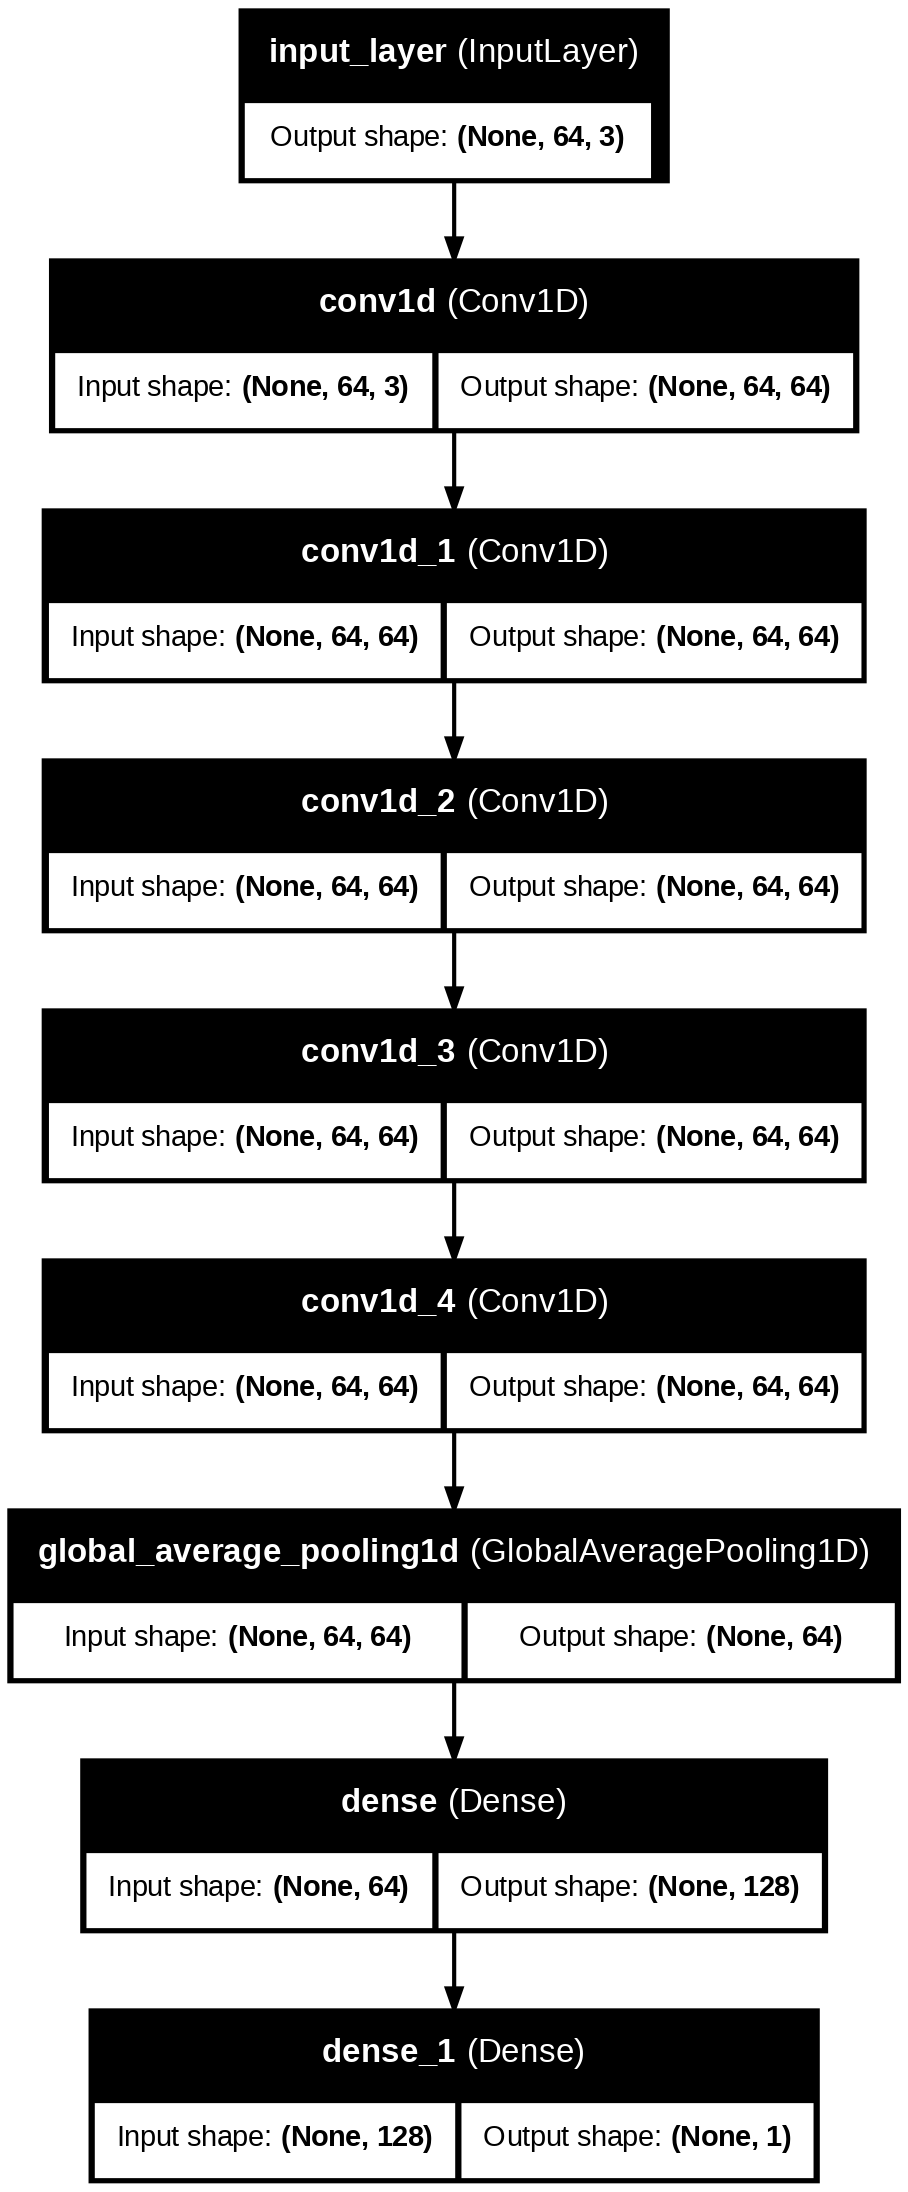

In [12]:



plot_model(
    reg,
    to_file="figures/dilated_cnn_arch.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=150
)



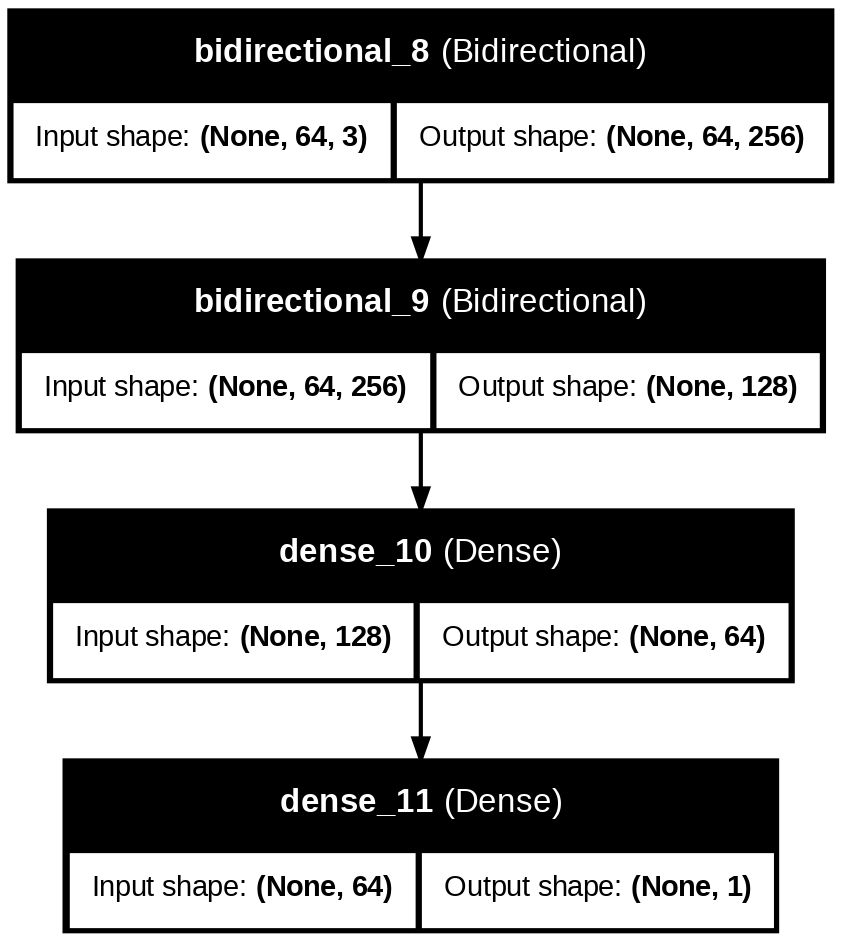

In [19]:
# Build the model manually (!important before plotting)
clf.build(input_shape=(None, WIN, len(FEATS)))

# Now plot the model
plot_model(
    clf,
    to_file="figures/bilstm_classifier_arch.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=150
)


### Step 7: Setup Training Callbacks
We add EarlyStopping to prevent overfitting and ReduceLROnPlateau to reduce the learning rate when the model plateaus. These strategies are essential for stabilising training and improving convergence.


In [21]:

cb=[EarlyStopping(patience=20,restore_best_weights=True),
    ReduceLROnPlateau(patience=6,factor=.3,min_lr=1e-5)]


### Step 8: Train Both Models
We train the CNN regressor and the Bi-LSTM classifier using their respective loss functions. We evaluate both on the validation set to monitor performance and apply the callbacks configured earlier.


In [22]:

hist_reg = reg.fit(X_tr,y_r_tr,validation_data=(X_va,y_r_va),
                   epochs=150,batch_size=32,callbacks=cb,verbose=0)
hist_clf = clf.fit(X_tr,y_c_tr,validation_data=(X_va,y_c_va),
                   epochs=150,batch_size=32,callbacks=cb,verbose=0)

### Step 9: Evaluate Regression Model on Test Set
We use the trained CNN model to predict CO₂ on the test set and compute Mean Absolute Error (MAE) and R² score. These metrics help us understand how closely the model's predictions align with actual CO₂ concentrations.


In [23]:


#regression metrics & plots
pr = reg.predict(X_te,verbose=0).flatten()
mae = mean_absolute_error(y_r_te,pr)
r2  = r2_score(y_r_te,pr)
print(f"\nRegression  MAE {mae:.2f} ppm  R² {r2:.2f}")


Regression  MAE 2.62 ppm  R² 0.98


### Step 10: Evaluate Classifier Model on Test Set
We use the Bi-LSTM to classify climate states in the test set and compute metrics like AUC, F1-score, and confusion matrix. These metrics evaluate how well the model distinguishes warm vs. cold periods.


In [24]:

#classification metrics & plots
pc   = clf.predict(X_te,verbose=0).flatten()
auc  = roc_auc_score(y_c_te,pc)
pred = (pc>=0.5).astype(int)
print(f"\nClassification  AUC {auc:.3f}")
print(classification_report(y_c_te,pred,digits=3))
cm   = confusion_matrix(y_c_te,pred)


Classification  AUC 0.982
              precision    recall  f1-score   support

         0.0      0.925     0.958     0.941       142
         1.0      0.920     0.863     0.890        80

    accuracy                          0.923       222
   macro avg      0.923     0.910     0.916       222
weighted avg      0.923     0.923     0.923       222



### Step 11: Visualise All Key Results
We generate a comprehensive figure including:  
- Training/validation loss curves  
- Actual vs. predicted CO₂ (scatter and time-series)  
- ROC curve for classification  
- Confusion matrix

This allows us to summarise model performance visually and confirm training stability.


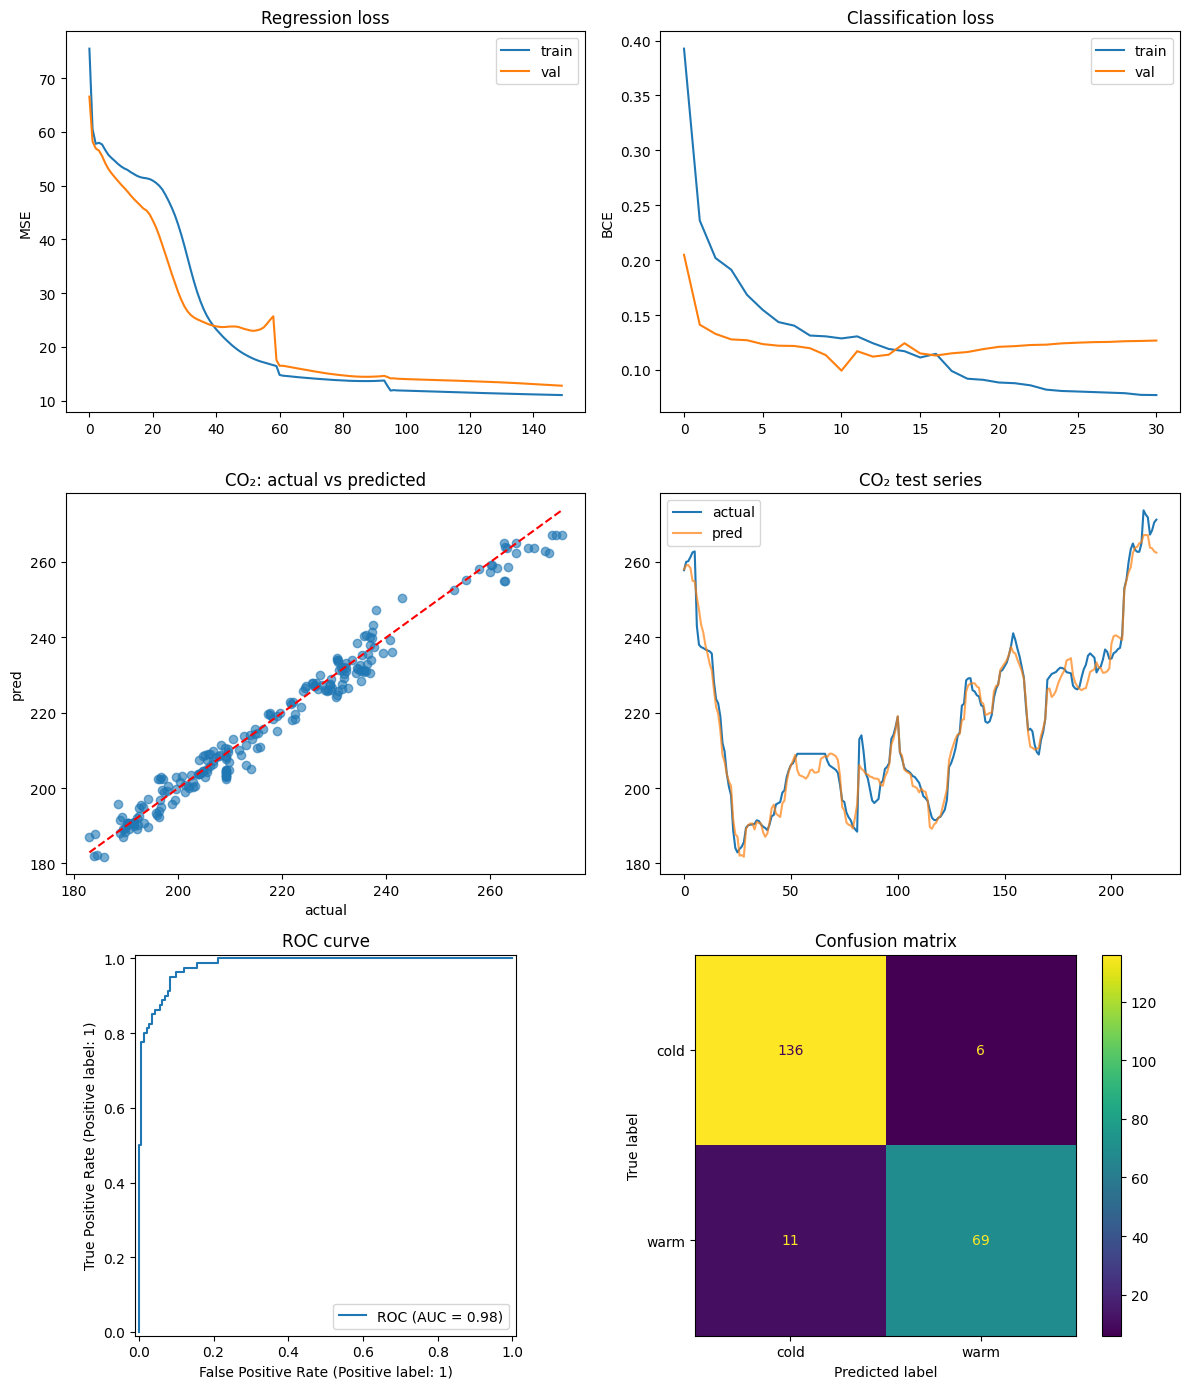


Figure saved to figures/vostok_all_plots.png


In [25]:
# Figure with six subplots
fig,ax = plt.subplots(3,2,figsize=(12,14)); ax=ax.ravel()

# 1 reg training curve
ax[0].plot(hist_reg.history['loss'],label='train')
ax[0].plot(hist_reg.history['val_loss'],label='val')
ax[0].set_title('Regression loss'); ax[0].set_ylabel('MSE'); ax[0].legend()

# 2 clf training curve
ax[1].plot(hist_clf.history['loss'],label='train')
ax[1].plot(hist_clf.history['val_loss'],label='val')
ax[1].set_title('Classification loss'); ax[1].set_ylabel('BCE'); ax[1].legend()

# 3 scatter actual vs pred CO₂
ax[2].scatter(y_r_te,pr,alpha=.6)
rng=[y_r_te.min(),y_r_te.max()]; ax[2].plot(rng,rng,'r--')
ax[2].set_title('CO₂: actual vs predicted'); ax[2].set_xlabel('actual'); ax[2].set_ylabel('pred')

# 4 time-series overlay
ax[3].plot(y_r_te,label='actual'); ax[3].plot(pr,label='pred',alpha=.7)
ax[3].set_title('CO₂ test series'); ax[3].legend()

# 5 ROC curve
RocCurveDisplay.from_predictions(y_c_te,pc,ax=ax[4],name='ROC')
ax[4].set_title('ROC curve')

# 6 confusion matrix
ConfusionMatrixDisplay(cm,display_labels=['cold','warm']).plot(ax=ax[5],values_format='d')
ax[5].set_title('Confusion matrix')

plt.tight_layout(); plt.savefig('figures/vostok_all_plots.png',dpi=200)
plt.show()

print("\nFigure saved to figures/vostok_all_plots.png")


### Step 12: Run Generalisation Check on Future Hold-out
We evaluate both models on a "future hold-out" set (the last 10% of windowed data) to test whether they generalise well to unseen future-like data. This acts as a sanity check for overfitting.


In [26]:
# 1.  pure-future test: last 10 % of *start indices*
future_idx = np.where(groups >= int(0.9*groups.max()))[0]
X_future, y_r_future, y_c_future = X_raw[future_idx], y_reg_raw[future_idx], y_cls_raw[future_idx]
X_future = scale(X_future)

print("Future windows:", len(future_idx))
print("Future MAE:", mean_absolute_error(y_r_future, reg.predict(X_future).flatten()))
print("Future AUC:", roc_auc_score(y_c_future, clf.predict(X_future).flatten()))


Future windows: 112
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Future MAE: 2.675682544708252
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Future AUC: 0.9944444444444444


## Conclusion


The Dilated-CNN regression model predicted CO$_2$ concentrations with impressive accuracy, achieving a mean absolute error (MAE) of just 2.7 ppm and an R$^2$ of 0.98. The Bi-LSTM climate classifier demonstrated similarly robust performance, correctly classifying climatic states with an AUC of 0.98 and an F1-score of 0.92.